In [1]:
import pandas as pd
import pytrends
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
from pytrends.request import TrendReq

In [3]:
pytrends = TrendReq(hl='en-US', tz=360)

In [4]:
kw_list =["ESG"]
pytrends.build_payload(kw_list, geo ='GR')

In [5]:
df=pytrends.interest_over_time()

In [6]:
df.to_csv("greekGoogleTrendEsg.csv",sep=';')
df.head()
df['ESG'].dtype

dtype('int64')

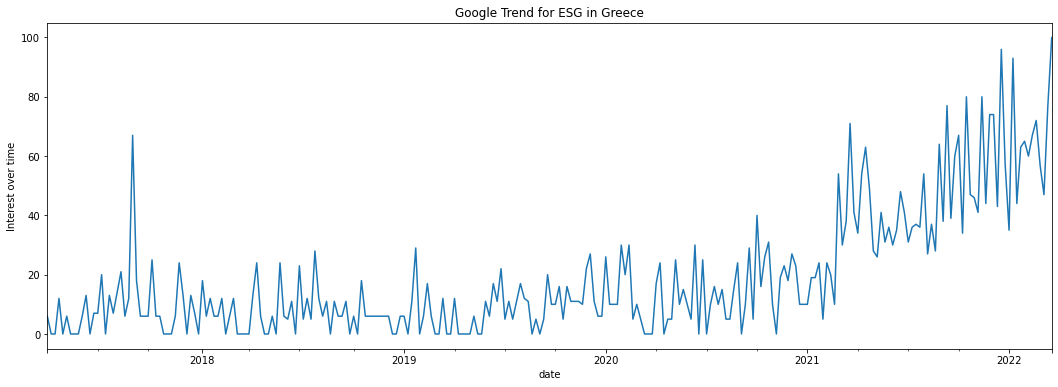

In [7]:
title='Google Trend for ESG in Greece'
ylabel='Interest over time'
ax=df['ESG'].plot(figsize=(18,6),title=title)
ax.set(ylabel=ylabel);

## ETS Decompositon model

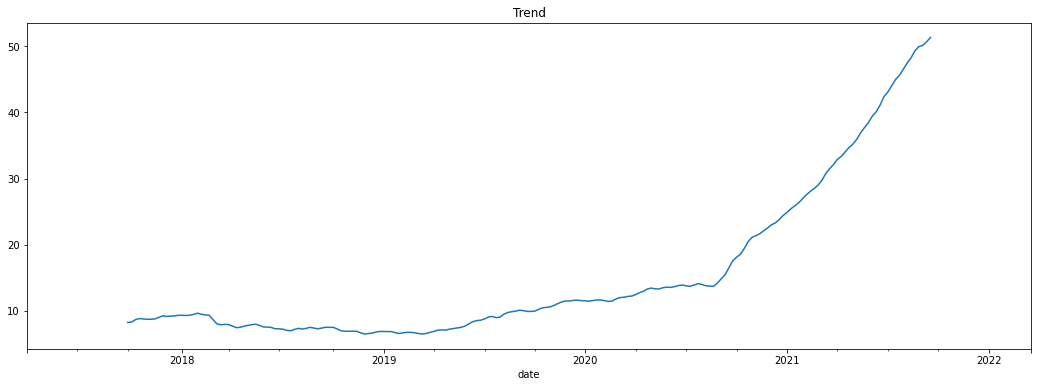

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize']=18,6


df.dropna(inplace=True)
result=seasonal_decompose(df['ESG'],model='additive')
result.trend.plot(title = "Trend");

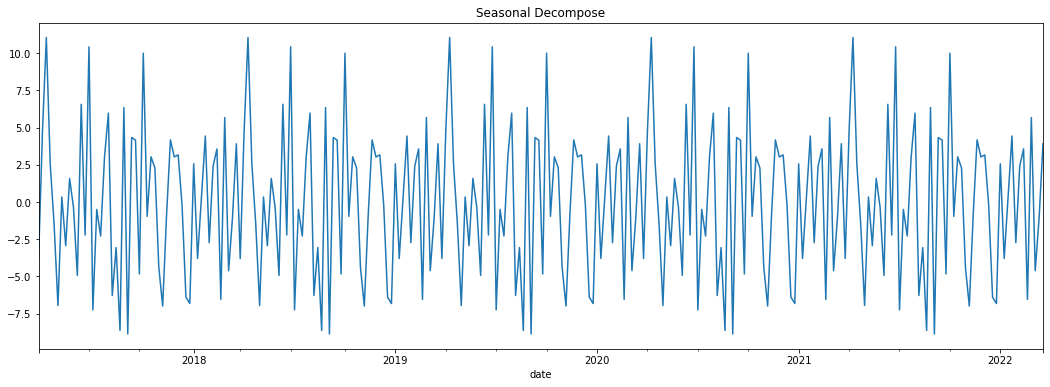

In [9]:
result.seasonal.plot(title="Seasonal Decompose", figsize=(18,6));

## 6-Month Simple Moving Average(SMA)

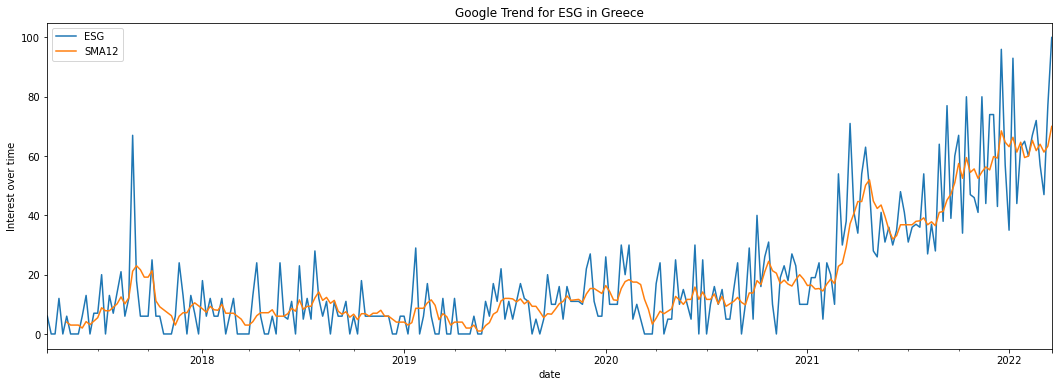

In [10]:
# 12months Simple Moving Average
df['SMA12']=df['ESG'].rolling(window=6).mean()
df[['ESG','SMA12']].plot(figsize=(18,6), title = title).set(ylabel = ylabel);

## Adding Exponentially Weighted Movining Average(EWMA) with 6 month span

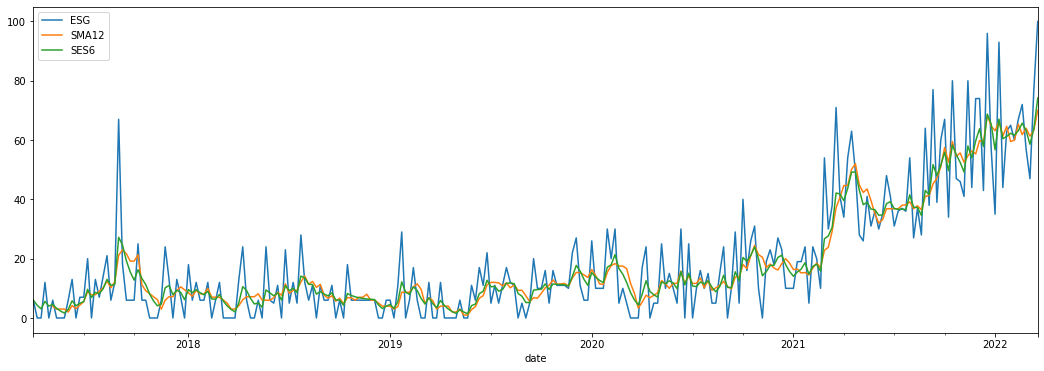

In [11]:
df['SES6']=df['ESG'].ewm(span=6,adjust=False).mean()
# df.head()
df[['ESG','SMA12','SES6']].plot();

## Adding Holt-Winters fitted model using Triple Exponential Smoothing with additive model

/home/giorgos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


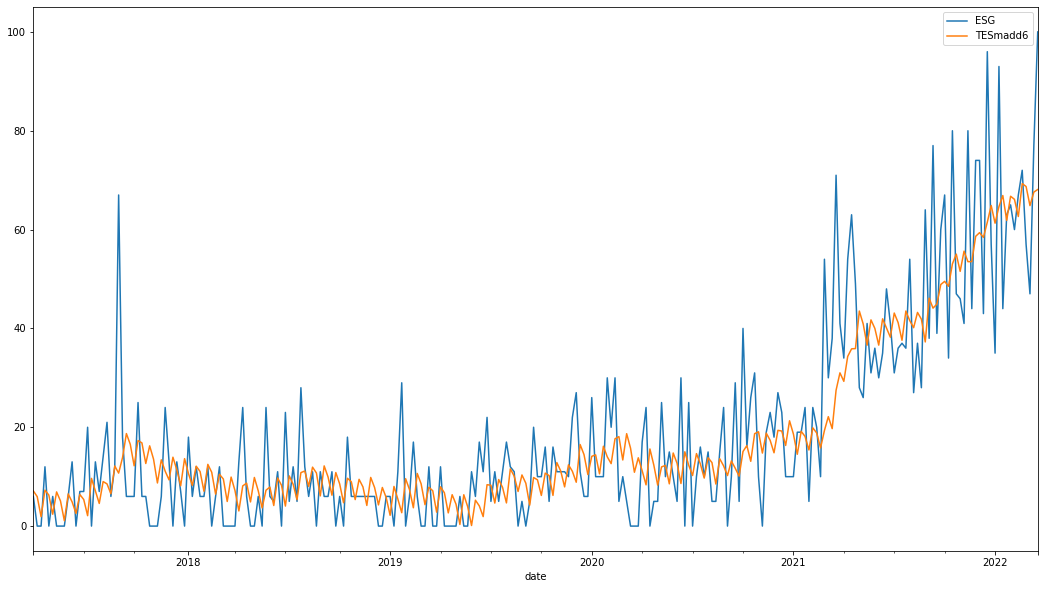

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df['TESmadd6']=ExponentialSmoothing(df['ESG'],trend='add',seasonal='add',seasonal_periods=6).fit().fittedvalues;
# df.head()
# df.columns
df[['ESG','TESmadd6']].plot(figsize=(18,10));

### ESG google search in Greece for the last 2 years

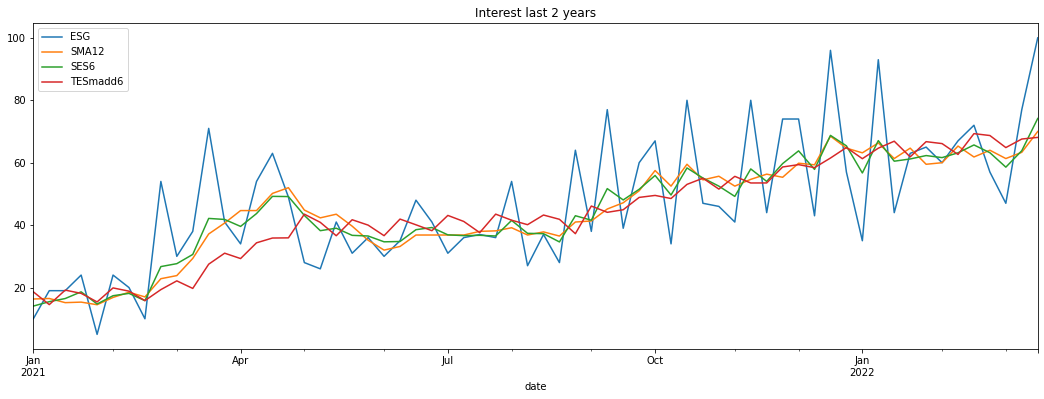

In [13]:
df[['ESG', 'SMA12', 'SES6', 'TESmadd6']]['2021-01-01':].plot(title='Interest last 2 years');

# Forcasting ESG google trend for Greece

## 1. Forecast with Holt-Winters model

In [14]:
# Split Data set to Train-Test set
df.info()
train_set = round(261*.8)
test_set = len(df)-train_set
train=df.iloc[:train_set]
test = df.iloc[train_set-5:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2017-04-02 to 2022-03-20
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ESG        260 non-null    int64  
 1   isPartial  260 non-null    bool   
 2   SMA12      255 non-null    float64
 3   SES6       260 non-null    float64
 4   TESmadd6   260 non-null    float64
dtypes: bool(1), float64(3), int64(1)
memory usage: 18.5 KB


In [15]:
train.tail()

,ESG,isPartial,SMA12,SES6,TESmadd6
date,,,,,
2021-02-28,54,False,22.833333,26.719859,19.341687
2021-03-07,30,False,23.833333,27.657042,22.145039
2021-03-14,38,False,29.333333,30.612173,19.721539
2021-03-21,71,False,37.166667,42.151552,27.486911
2021-03-28,41,False,40.666667,41.822537,31.012420


In [16]:
test.head()

,ESG,isPartial,SMA12,SES6,TESmadd6
date,,,,,
2021-02-28,54,False,22.833333,26.719859,19.341687
2021-03-07,30,False,23.833333,27.657042,22.145039
2021-03-14,38,False,29.333333,30.612173,19.721539
2021-03-21,71,False,37.166667,42.151552,27.486911
2021-03-28,41,False,40.666667,41.822537,31.012420


In [17]:
# Fit the model
fitted_model = ExponentialSmoothing(train['ESG'],trend='add',seasonal='add').fit()

/home/giorgos/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [18]:
# Forecast against test set
test_pred = fitted_model.forecast(90)
test_pred

2021-04-04    46.360768
2021-04-11    47.880831
2021-04-18    40.356756
2021-04-25    37.090407
2021-05-02    38.591298
                ...    
2022-11-20    61.280773
2022-11-27    60.296612
2022-12-04    60.552665
2022-12-11    57.307191
2022-12-18    51.315496
Freq: W-SUN, Length: 90, dtype: float64

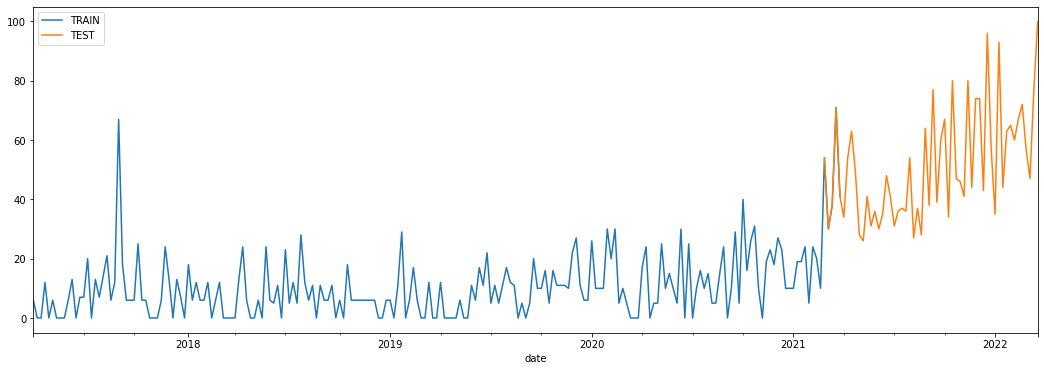

In [19]:
# plot train and test data
train['ESG'].plot(legend = True, label = 'TRAIN')
test['ESG'].plot(legend = True, label = 'TEST');

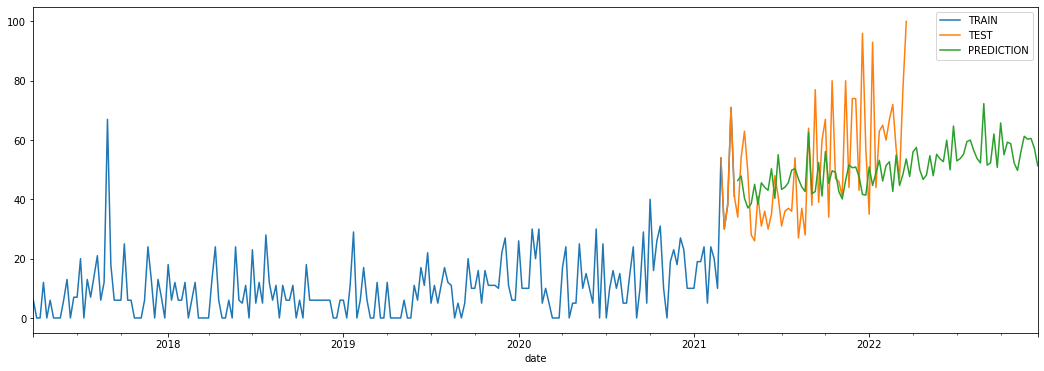

In [20]:
# Plot with prediction
train['ESG'].plot(legend = True, label = 'TRAIN')
test['ESG'].plot(legend = True, label = 'TEST')
test_pred.plot(legend = True, label='PREDICTION');

## 2. Exposing Seasonality on Monthly base-plot

<AxesSubplot:xlabel='date'>

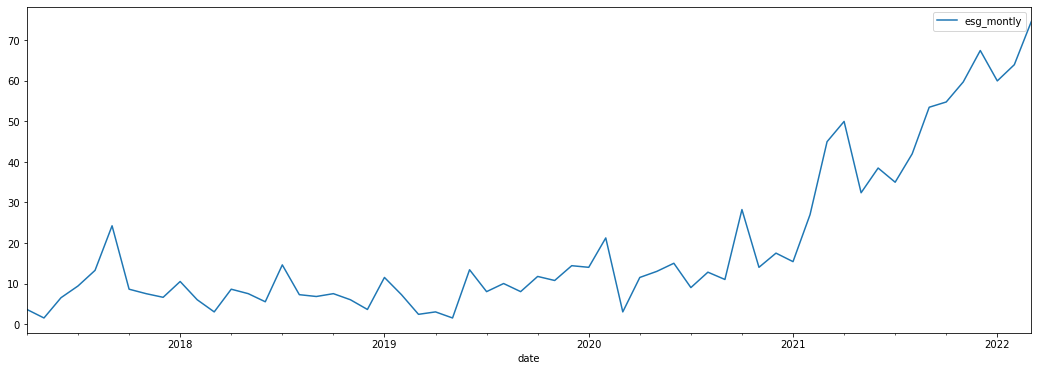

In [21]:
from statsmodels.graphics.tsaplots import month_plot
dfMonthly = df['ESG'].resample(rule='M').mean().rename('esg_montly')
dfMonthly.plot(legend = 'True')

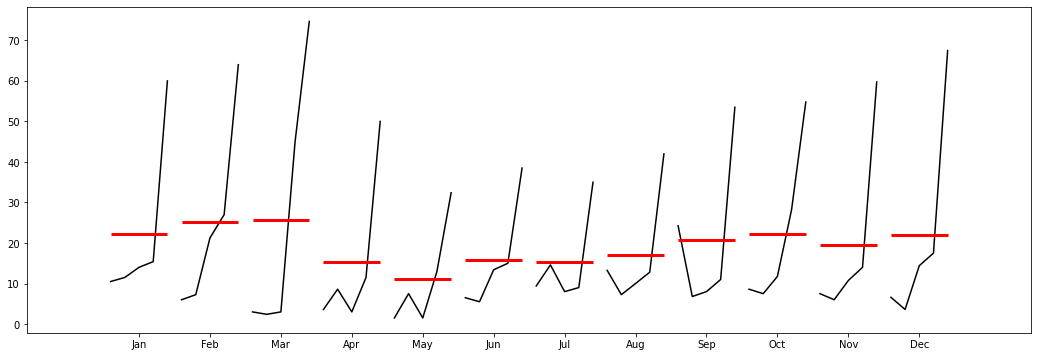

In [22]:
month_plot(dfMonthly);

## 3. Test for Stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
adfuller(dfMonthly)

(2.9456342660557,
 1.0,
 7,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 318.7948977747661)

p-value  = 1.0 therefore data is nonstationary(0.05< for stationary), needs Differencing for ARIMA model

## 4. Run acf and pacf plots

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

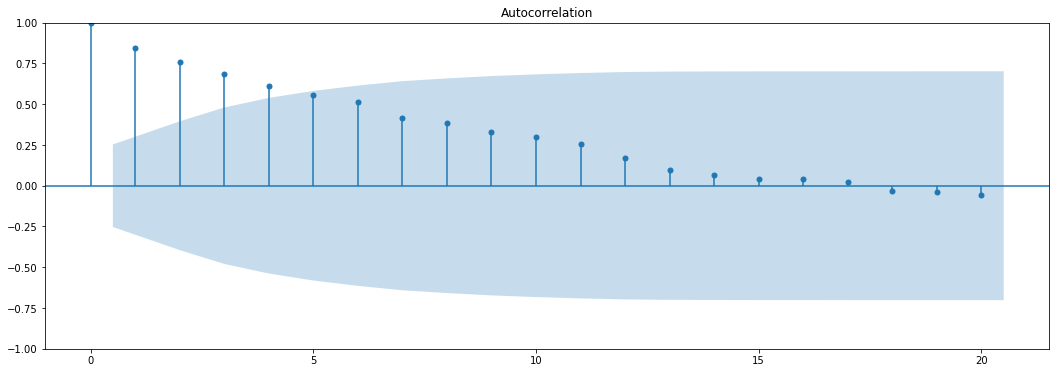

In [26]:
plot_acf(dfMonthly, lags=20);

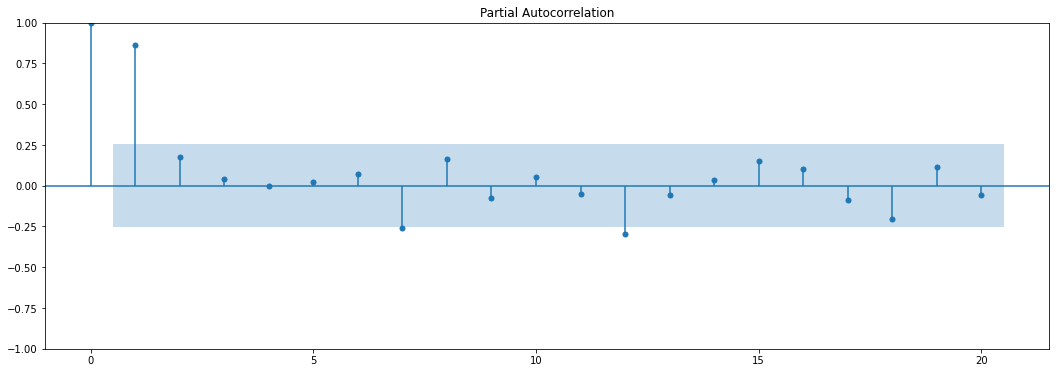

In [27]:
plot_pacf(dfMonthly, lags=20);

## 5. Forecast with SARIMA model

In [165]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [166]:
auto_arima(dfMonthly, seasonal=True,trace=True,max_p=5,max_d=5,max_q=5,maxiter=300,m=6).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=402.246, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=407.170, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=399.386, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=396.558, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=406.724, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=401.975, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=398.333, Time=0.09 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=398.284, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=396.740, Time=0.05 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=400.281, Time=0.16 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=400.415, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=397.355, Time=0.07 sec
 ARIMA(0,1,2)(0,0,1)[6] intercept   : AIC=397.180, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=398.860, Time=0.06 sec
 ARIMA(1,1,2)(0,0,1)[6] intercept   : AIC=399.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood                -194.279
Date:                           Mon, 28 Mar 2022   AIC                            396.558
Time:                                   01:36:08   BIC                            404.868
Sample:                                        0   HQIC                           399.802
                                            - 60                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2444      0.788      1.578      0.114      -0.301       2.790
ma.L1         -0.3999      0.122     -3.287      0.001      -0.638      -0.161
ma.S.L6        0.3906      0.147      2.664      0.008       0.103       0.678
sigma2        41.6006      6.925      6.007      0.000      28.028      55.173
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 2.18
Prob(Q):                              0.67   Prob(JB):                         0.34
Heteroskedasticity (H):               1.92   Skew:                             0.30
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
# split data
len(dfMonthly)
train =dfMonthly.iloc[:56]
test = dfMonthly.iloc[56:]

In [183]:

model = SARIMAX(train,order=(0,1,1),seasonal_order=(0,0,1,6))
result = model.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26912D+00    |proj g|=  4.58583D-02

At iterate    5    f=  3.25582D+00    |proj g|=  1.06742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   7.187D-07   3.256D+00
  F =   3.2555938223024325     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [184]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        esg_montly   No. Observations:                   56
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 6)   Log Likelihood                -182.313
Date:                           Mon, 28 Mar 2022   AIC                            370.627
Time:                                   01:38:35   BIC                            376.649
Sample:                               04-30-2017   HQIC                           372.955
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3795      0.111     -3.428      0.001      -0.597      -0.162
ma.S.L6        0.3985      0.147      2.707      0.007       0.110       0.687
sigma2        43.3819      7.311      5.934      0.000      29.052      57.711
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.88   Prob(JB):                         0.27
Heteroskedasticity (H):               2.15   Skew:                             0.32
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [185]:
# Predict
start = len(train)
end = len(train)+len(test)-1

In [186]:
predictions = result.predict(start=start,end=end,typ='levels').rename('SARIMA Prediction')

In [187]:
predictions

2021-12-31    57.605716
2022-01-31    56.101498
2022-02-28    57.135527
2022-03-31    59.208980
Freq: M, Name: SARIMA Prediction, dtype: float64

<AxesSubplot:xlabel='date'>

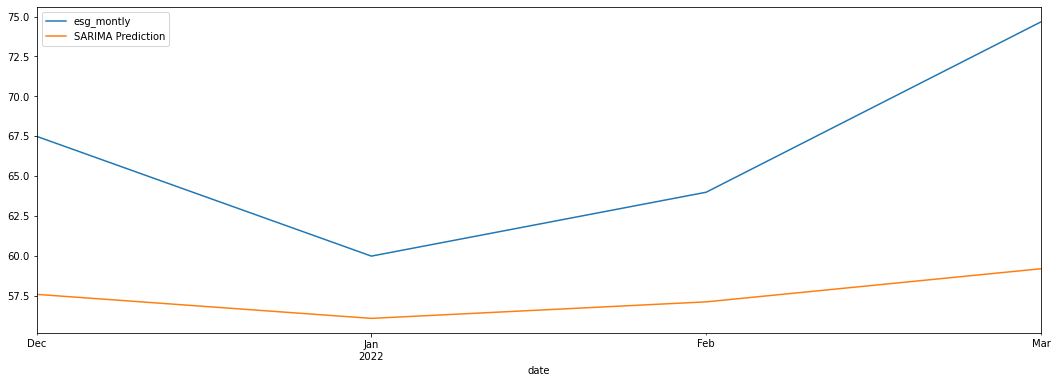

In [188]:
test.plot(legend=True)
predictions.plot(legend=True)

In [189]:
# Evaluation
from statsmodels.tools.eval_measures import rmse
error = rmse(test,predictions)
print(f'RMSE error: {error:.5}')

RMSE error: 9.9894


In [190]:
test.mean()

66.54166666666667

In [191]:
# Retrain the model on the full data, and forecast 3 months

In [195]:
model = SARIMAX(dfMonthly,order=(0,1,1),seasonal_order=(0,0,1,6))
results=model.fit()
len(dfMonthly)
fcast=results.predict(start=len(dfMonthly)-1,end=len(dfMonthly)+3,typ='levels').rename('SARIMA ESG FORECAST 3months')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27374D+00    |proj g|=  3.89506D-02

At iterate    5    f=  3.26155D+00    |proj g|=  4.18808D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.096D-07   3.262D+00
  F =   3.2615001463537103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


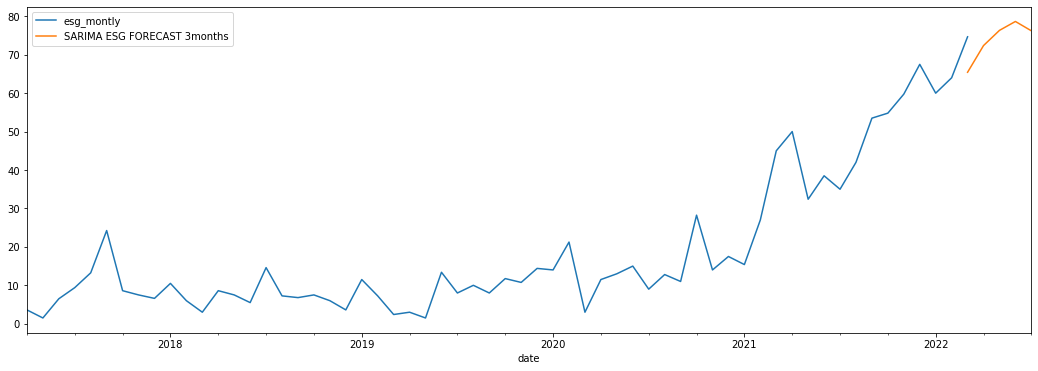

In [196]:
dfMonthly.plot(legend=True)
fcast.plot(legend=True);